In [1]:
import torch
import torchvision
import numpy as np 
from PIL import Image
import onnxruntime as ort 
import matplotlib.pyplot as plt
from torchvision import transforms as T

In [2]:
IMAGE_SIZE = 640
class_names = ["cat", "duck"]
model_path = "yolov5_custom.onnx"

In [3]:
def to_tensor(image_path: str) :
    transformer = T.Compose([T.Resize((IMAGE_SIZE, IMAGE_SIZE))])
    image = torchvision.io.read_image(image_path).type(torch.float32) / 255.
    image_transform = transformer(image)
    return image, image_transform.to("cpu")

def infer_onnx_model(model_path, input_data):
    session = ort.InferenceSession(model_path)
    # Convert input data to a format that can be fed into the model
    input_name = session.get_inputs()[0].name
    input_data = {input_name: np.array(input_data, dtype=np.float32)}
    output = session.run(None, input_data)
    return output

In [4]:
def xywh2xyxy(x) :
    """center (x,y) to top-left and bottom-right"""
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y

def xyxy2xywh(x):
    """Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right."""
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = (x[..., 0] + x[..., 2]) / 2  # x center
    y[..., 1] = (x[..., 1] + x[..., 3]) / 2  # y center
    y[..., 2] = x[..., 2] - x[..., 0]  # width
    y[..., 3] = x[..., 3] - x[..., 1]  # height
    return y

In [5]:
image_path = "test-image.jpg"
original_image, image_tensor = to_tensor(image_path)

c:\Users\alant\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [6]:
predict = infer_onnx_model(model_path, image_tensor.reshape(1, 3, IMAGE_SIZE, IMAGE_SIZE))
len(predict), predict[0].shape

(1, (1, 25200, 7))

In [7]:
predict = predict[0]
predict.shape

(1, 25200, 7)

In [8]:
predict[0][24] # example 24th box

array([1.97935303e+02, 6.92852211e+00, 2.28853416e+01, 6.79465532e+00,
       1.00165606e-04, 1.53648585e-01, 6.06789291e-01], dtype=float32)

In [9]:
conf_thres = 0.3
iou_threses = 0.45
prediction = torch.from_numpy(predict)
batch_size = prediction.shape[0]
num_classes = prediction.shape[2] - 5 # remove x,y,w,h,conf
xc = prediction[..., 4] > conf_thres  
marks_idx = 5 + num_classes # marsk start idx
xc, xc.shape, xc.sum()

(tensor([[False, False, False,  ..., False, False, False]]),
 torch.Size([1, 25200]),
 tensor(86))

In [10]:
max_wh = 7680 # (pixels) maximum box width and height
max_nms = 30000 # maximum number of boxes
max_det = 300 # limit detections
output = [torch.zeros((0, 6))] * batch_size # just emtpy torch tensor
output

[tensor([], size=(0, 6))]

In [11]:
from torchvision.ops.boxes import box_iou

def non_max_supression(boxes, iou_thres) :
    idxs = torch.arange(boxes.shape[0])
    keeps = torch.ones_like(idxs, dtype=torch.bool)
    for idx in idxs :
        if keeps[idx] :
            bbox = boxes[idx] 
            # same as box_iou format
            # TODO: box_iou
            iou = box_iou(bbox.reshape(1, -1), (boxes[idxs[idx+1:]])*keeps[idx+1:].reshape(-1, 1))
            # return idx true if more than iou_thres
            overlapped = torch.nonzero(iou > iou_thres)
            keeps[overlapped+idx+1] = 0
    return idxs[keeps]

In [12]:
for batch_idx, x in enumerate(prediction) :
    x = x[xc[batch_idx]] # get only prediction more than conf_thres 
    x[:, 5:] *= x[:, 4].reshape(-1,1) # conf = obj_conf * cls_conf
    box = xywh2xyxy(x[:, :4])
    mask = x[:, marks_idx: ] # zero colums if no masks
    
    # get probas and class_idx
    probas, class_idx = x[:, 5:marks_idx].max(dim=1, keepdim=True)
    x = torch.cat((box, probas, class_idx.float(), mask), dim=1)
    # get only probas > conf_thres
    x = x[probas.view(-1,) > conf_thres]
    # sort by probas and remove if excess boxes
    x = x[x[:, 4].argsort(descending=True)[:max_nms]]

    # adjust to format of nms torch
    # class_idx * max_wh
    c = x[:, 5].reshape(-1,1)*(max_wh)
    boxes, probas = x[:, :4] + c, x[:, 4] # boxes(offset by class), scores
    # non max supression
    idx = non_max_supression(boxes, iou_threses)
    idx = idx[:max_det]
    output[batch_idx] = x[idx]

In [13]:
idx

tensor([ 0,  2,  4, 10])

In [14]:
output = output[0]
output

tensor([[ 60.8622, 148.0403, 217.8511, 352.7934,   0.7819,   0.0000],
        [404.6473, 387.4651, 469.6169, 465.5590,   0.7462,   1.0000],
        [477.9381, 221.1964, 566.0205, 306.5070,   0.7109,   1.0000],
        [ -2.4810, 288.7940,  77.5815, 534.0575,   0.6825,   1.0000]])

In [15]:
xyxy = output[:, :4]
xywh = xyxy2xywh(xyxy)
output[:, :4] = xywh
output

tensor([[139.3566, 250.4169, 156.9890, 204.7530,   0.7819,   0.0000],
        [437.1321, 426.5121,  64.9695,  78.0938,   0.7462,   1.0000],
        [521.9793, 263.8517,  88.0824,  85.3107,   0.7109,   1.0000],
        [ 37.5502, 411.4257,  80.0625, 245.2635,   0.6825,   1.0000]])

In [16]:
import matplotlib.patches as patches

def draw_bbox_on_image(image, bboxes, color='r', save_path=None):
    image = image.permute(1, 2, 0)
    fig, ax = plt.subplots()
    ax.imshow(image)
    color_class = ["black", "yellow"]
    # (x, y): from center
    # but matplotlib start from top-left
    for boxes in bboxes :
        x, y, w, h, probas, class_idx = boxes
        text = f"{class_names[class_idx]}: {probas}"
        top_left_x = x-w//2
        top_left_y = y-h//2
        rect = patches.Rectangle((top_left_x, top_left_y), w, h, linewidth=1, edgecolor=color_class[class_idx], facecolor='none')
        plt.text(top_left_x, top_left_y-10, text, fontsize=10, color=color_class[class_idx])
        ax.add_patch(rect)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)  # Close the figure to prevent displaying it
        print(f"saved: {save_path}")
    else:
        plt.show()

def rescale_bbox(boxes, input_shape):
    x, y, w, h, probas, class_idx = boxes
    # Calculate scaling factors
    scale_x = input_shape[2] / IMAGE_SIZE
    scale_y = input_shape[1] / IMAGE_SIZE

    # Rescale bounding box coordinates
    x_rescaled = x * scale_x
    y_rescaled = y * scale_y
    w_rescaled = w * scale_x
    h_rescaled = h * scale_y

    return x_rescaled, y_rescaled, w_rescaled, h_rescaled, round(float(probas), 2), int(class_idx)

In [17]:
if output.shape[0] != 0 :
    rescale_bboxes = [rescale_bbox(boxes, original_image.shape) for boxes in output]
    draw_bbox_on_image(original_image, rescale_bboxes, save_path="test2.jpg")

saved: test2.jpg


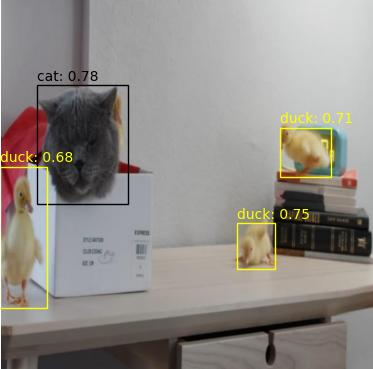

In [18]:
Image.open("test2.jpg")